In [47]:
import cv2
import numpy as np
import pandas as pd
from scipy.signal import convolve2d
from scipy.signal import correlate2d
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift

In [48]:
def bilinear_interpolation(image: np.array,scale_x:float,scale_y:float):
    old_height, old_width = image.shape
    M = int(scale_x * image.shape[0])
    N= int (scale_y*image.shape[1])
    row_scale = (old_height) / M
    col_scale = (old_width) / N
    
    resized_image = np.zeros((M, N), dtype=np.float32)

    for i in range(M):
        for j in range(N):
            i_old = i * row_scale
            j_old = j * col_scale
            
            x1 = int(np.floor(i_old))
            y1 = int(np.floor(j_old))
            x2 = min(x1 + 1, old_height - 1)
            y2 = min(y1 + 1, old_width - 1)
            
            f11 = image[x1, y1]
            f12 = image[x1, y2]
            f21 = image[x2, y1]
            f22 = image[x2, y2]
            
            d_i = i_old - x1
            d_j = j_old - y1
            
            linear1 = (1 - d_j) * f11 + d_j * f12
            linear2 = (1 - d_j) * f21 + d_j * f22
            
            resized_image[i, j] = (1 - d_i) * linear1 + d_i * linear2
    
    return resized_image

In [49]:
image_1 = cv2.imread("data/my_image.png",cv2.IMREAD_ANYDEPTH)


In [50]:
aliased_image = bilinear_interpolation(image_1,0.15,0.15)
cv2.imwrite("output_images/Q2/alised_image.png",aliased_image)

True

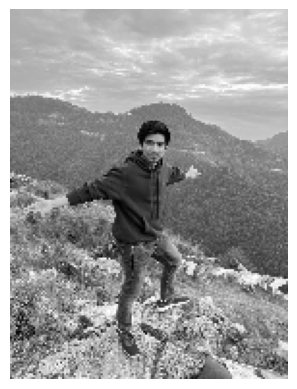

In [51]:
plt.imshow(aliased_image, cmap='gray')
plt.axis('off')
plt.show()
